
**Hackathon RIIAA 2021 "JusticIA para los desaparecidos"**

Equipo **MITOTEC**
Integrantes


*   Alfredo Sepúlveda Sastre
*   Carlos Ortíz López 
*   Daniel García Hernández
*   Rossana Tornel Vázquez 





## Descripción 
El objetivo de este trabajo es encontrar un patrones dentro de las fichas para conocer el *sistema de referencias* que la Dirección Federal de Seguridad (DFS) utilizó durante el periodo conocido como la Guerra Sucia. 

##Pipeline


1.   La base de datos utilizada es la transcripción manual de las fichas (1000 observaciones).
2.   Pos tagging con spacy spanish.
1.   Extracción de los nombres propios "PROPN"
2.   Extracción de expedientes 
1.   Extracción número de Hoja y Legajo
1.   Creación de variables dummy de palabras clave: muerto, detenido, secuestro, interrogado, localizar, ...
2.   Matriz de similitud de las fichas.







# Tagging con spaCy 



> Instalar paqueterías requeridas


In [1]:
# install the requirements
!pip install spacy
!python -m spacy download es_core_news_sm

     |████████████████████████████████| 16.2 MB 8.0 MB/s 
  Created wheel for es-core-news-sm: filename=es_core_news_sm-2.2.5-py3-none-any.whl size=16172933 sha256=9a51eb9b858f554219eebf29a1e95072b4d8ed07c6d03a0b65557d5697c2205d
  Stored in directory: /tmp/pip-ephem-wheel-cache-eo9ymwgl/wheels/21/8d/a9/6c1a2809c55dd22cd9644ae503a52ba6206b04aa57ba83a3d8
Successfully built es-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')


In [46]:
#nuveo cuaderno push
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from math import sqrt
import scipy.spatial.distance as ssd
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [3]:
# montar el google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Creación de una copia del archivo en drive. Path para leerlo
file = pd.read_csv('drive/My Drive/Copia de JusticIA_DatosTranscripciones.csv')
file.columns

Index(['Fuente', 'Conjunto', 'NombreArchivo', 'Texto', 'MetodoTexto'], dtype='object')

In [5]:
# filtrar a trasncripcion manual
file_manual = file[file.MetodoTexto == 'manual']

In [6]:
# sacar una ficha para pruebas
texto_0 = file_manual.Texto[4]
texto_0

'BIGOTES, El. Exp.100-10-16-4-72\nH-195 L-2\n10-Feb-72.-Seudónimo de un elemento que MIGUEL\nDUARTE LOPEZ (Fuerzas Armadas de la Nueva Revo-\nlución), trajo al D.F., después de que en Sono-\nra efectuó la -expropiación- a un Banco, en la\ncual obtuvieron $9,000.00.- LE acompañaban EL\nPATILLAS y EL CEJAS.-\nFol. 198.- En 1969 estos elementos eran de un\ngrupo revolucionario en Monterrey .-\nExp. 11-234-73.\nH-13 L-1.\n15-Jun-73.- El 14 del actual en el interroga-\ntorio efectuado a JUSTINO VILLEGAS ZUÑIGA, --'

In [7]:
# importar el spacy en español, regresa doc que es tiene la lista de palabras y su clasificacion
import es_core_news_sm
nlp = es_core_news_sm.load()
doc = nlp(texto_0)


In [8]:
# asi obtienes la clasificacion de las palabras
for tok in doc:
    print(tok, tok.pos_)

BIGOTES PROPN
, PUNCT
El DET
. PUNCT
Exp.100 NOUN
- PUNCT
10 NUM
- PUNCT
16 NUM
- PUNCT
4 NUM
- PUNCT
72 NUM

 SPACE
H-195 PROPN
L-2 NUM

 SPACE
10-Feb-72.-Seudónimo NUM
de ADP
un DET
elemento NOUN
que PRON
MIGUEL PROPN

 SPACE
DUARTE PROPN
LOPEZ PROPN
( PUNCT
Fuerzas PROPN
Armadas PROPN
de ADP
la DET
Nueva PROPN
Revo- PROPN

 SPACE
lución PROPN
) PUNCT
, PUNCT
trajo VERB
al ADP
D.F. PROPN
, PUNCT
después ADV
de ADP
que SCONJ
en ADP
Sono- PROPN

 SPACE
ra PROPN
efectuó VERB
la PRON
-expropiación- VERB
a ADP
un DET
Banco PROPN
, PUNCT
en ADP
la DET

 SPACE
cual PRON
obtuvieron VERB
$ NUM
9,000.00.- NOUN
LE PROPN
acompañaban VERB
EL DET

 SPACE
PATILLAS PROPN
y CONJ
EL DET
CEJAS.- PROPN

 SPACE
Fol PROPN
. PUNCT
198.- NUM
En ADP
1969 NOUN
estos DET
elementos NOUN
eran AUX
de ADP
un DET

 SPACE
grupo NOUN
revolucionario ADJ
en ADP
Monterrey PROPN
.- PUNCT

 SPACE
Exp PROPN
. PUNCT
11 NUM
- PUNCT
234 NUM
- PUNCT
73 NUM
. PUNCT

 SPACE
H-13 PROPN
L-1 PROPN
. PUNCT

 SPACE
15-Jun-73.- NUM
El



> Función para obtener nombres propios 



In [9]:
# Función para obtener nombres propios

def extract_proper_nouns(doc):
    pos = [tok.i for tok in doc if tok.pos_ == "PROPN"]
    consecutives = []
    current = []
    for elt in pos:
        if len(current) == 0:
            current.append(elt)
        else:
            if current[-1] == elt - 1:
                current.append(elt)
            else:
                consecutives.append(current)
                current = [elt]
    if len(current) != 0:
        consecutives.append(current)
    return [doc[consecutive[0]:consecutive[-1]+1] for consecutive in consecutives]

In [10]:
def quitar_saltos(text):
  text = text.replace('-\n', '')
  text = text.replace('\n', ' ')
  text = text.replace('-', '')
  text = text.replace('(', '.')
  text = text.replace(')', '.')
  return text

In [11]:
quitar_saltos(texto_0)

'BIGOTES, El. Exp.1001016472 H195 L2 10Feb72.Seudónimo de un elemento que MIGUEL DUARTE LOPEZ .Fuerzas Armadas de la Nueva Revolución., trajo al D.F., después de que en Sonora efectuó la expropiación a un Banco, en la cual obtuvieron $9,000.00. LE acompañaban EL PATILLAS y EL CEJAS.Fol. 198. En 1969 estos elementos eran de un grupo revolucionario en Monterrey .Exp. 1123473. H13 L1. 15Jun73. El 14 del actual en el interrogatorio efectuado a JUSTINO VILLEGAS ZUÑIGA, '

In [12]:
def nombres_propios(text):
  text = quitar_saltos(text)
  doc = nlp(text)
  nombres = extract_proper_nouns(doc)
  return nombres

In [13]:
def separar_mayusculas(texto):
  palabras_candidato = []
  nueva_palabra = 0
  nombre = ''
  palabras_conexion = ['de', 'de la']
  for word in texto.split():
    if not(word.islower()) or (nueva_palabra !=0 and word == 'de'):
      nueva_palabra = nueva_palabra +1
      if nueva_palabra != 0:
        nombre = nombre + ' ' + word
    else:
      if nombre != '' and re.search('[a-zA-Z]', nombre):
        #print(nombre)
        palabras_candidato.append(nombre[1:])
      nueva_palabra = 0
      nombre = ''
  palabras_candidato = [x.split('.',1)[0] for x in palabras_candidato]
  return palabras_candidato

In [14]:
def extraer_nombres_mano(text):
  text = quitar_saltos(text)
  lista_nombre = separar_mayusculas(text)
  lista_nombre = [x for x in lista_nombre if not re.search('Exp', x)]
  return lista_nombre

In [15]:
file_manual.Texto[4]

'BIGOTES, El. Exp.100-10-16-4-72\nH-195 L-2\n10-Feb-72.-Seudónimo de un elemento que MIGUEL\nDUARTE LOPEZ (Fuerzas Armadas de la Nueva Revo-\nlución), trajo al D.F., después de que en Sono-\nra efectuó la -expropiación- a un Banco, en la\ncual obtuvieron $9,000.00.- LE acompañaban EL\nPATILLAS y EL CEJAS.-\nFol. 198.- En 1969 estos elementos eran de un\ngrupo revolucionario en Monterrey .-\nExp. 11-234-73.\nH-13 L-1.\n15-Jun-73.- El 14 del actual en el interroga-\ntorio efectuado a JUSTINO VILLEGAS ZUÑIGA, --'

In [16]:
quitar_saltos(file_manual.Texto[2])

'GUEL ALEMAN, EMILIO AZCARRAGA ulotro personaje. Exp.10010162 H200 L6. 11Abril72. En un recado enviado por HILARIO ADAME HERNANDEZ hijo de este elemento a LEOVIGILDO PINZON TOLENTINO, menciona que este elemento fué muerto. Exp1001016272 H200L6. 11Abr72. En un recado enviado por HILARIO ADA ME HERNANDEZ hijo de éste elemento a LEOVIGILDO PINZON TOLENTINO menciona que éste elemento   . fue muerto. Exp.1001016472 H237 L6 2Oct72. SUS HIJOS: HILARIO y PASCUAL son miem bros permanentes del grupo de LUCIO CABAÑAS.'

In [17]:
def siglas(text):
  pattern3='(?:(?<=\.|\s)[A-Z]\.)+'
  return re.search(pattern3, text)

In [18]:
def buscar_h_l(text):
  pattern_h=r'([H][0-9])'
  pattern_l=r'([L][0-9])'
  return re.search(pattern_h, text) and re.search(pattern_l, text)

In [19]:
buscar_h_l('Juan')

In [20]:
def separar_nombres(text):
  palabras_separadas = quitar_saltos(text).split()
  palabras_separadas = [x.replace('Y', 'y') if len(x) == 1 else x for x in palabras_separadas]
  palabras_separadas = [x.replace('Exp', 'exp') for x in palabras_separadas]
  palabras_candidato = []
  nueva_palabra = 0
  nombre = ''
  #palabras_conexion = ['de', 'de la']
  for word in palabras_separadas:
    if not(word.islower()) or (nueva_palabra !=0 and word == 'de') or (nueva_palabra !=0 and word == 'la' and nombre.split()[-1] == 'de'):
      nueva_palabra = nueva_palabra +1
      if nueva_palabra != 0:
        nombre = nombre + ' ' + word
    else:
      if nombre != '' and re.search('[a-zA-Z]', nombre):
        #print(nombre)
        palabras_candidato.append(nombre[1:])
      nueva_palabra = 0
      nombre = ''
  if len(word) > 0:
    palabras_candidato.append(nombre[1:])
  #palabras_candidato = [word for line in palabras_candidato for word in line.split('.')]
  #palabras_candidato = [x.split('.',1)[0] for x in palabras_candidato]
  return palabras_candidato

In [21]:
palabras = separar_nombres(file_manual.Texto[8])

In [22]:
def limpiar_lista(lista_nombres):
  palabras_sin_folio = [nombre for nombre in lista_nombres if buscar_h_l(nombre) is None]
  separado = [nombre.split('.') if siglas(nombre) is None else nombre for nombre in palabras_sin_folio]
  separado = [palabra if isinstance(lista, list) else lista for lista in separado for palabra in lista]
  separado = [nombre for nombre in separado if re.search('[a-zA-Z]', nombre)]
  separado = [nombre for nombre in separado if not re.search('[0-9]', nombre)]
  separado = [nombre.strip() for nombre in separado]
  separado = list(dict.fromkeys(separado))
  #separado.remove('Fol')
  return separado


In [23]:
limpiar_lista(palabras)

['FLORES BELLO,', 'NORBERTO RAMIREZ,', 'SALVADOR', 'NORBERTO', 'RAMIRO']

In [24]:
def extraer_nombres(texto):
  nombres = separar_nombres(texto)
  lista_limpia = limpiar_lista(nombres)
  return lista_limpia

In [25]:
extraer_nombres(file_manual.Texto[8])

['FLORES BELLO,', 'NORBERTO RAMIREZ,', 'SALVADOR', 'NORBERTO', 'RAMIRO']

In [26]:
from tqdm import tqdm
nombres = []
for ficha in tqdm(file_manual.Texto):
  nombres.append(extraer_nombres(ficha))

100%|██████████| 1000/1000 [00:00<00:00, 3914.76it/s]


In [27]:
file_manual['nombres'] = file_manual.Texto.apply(extraer_nombres, 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
file_manual['nombres']

0      [ADAME FLORE Samuél, Atoyac de Alvarez Gro, Pa...
1      [ADAME FLORES Samuél, CLISERIO DE JESUS ARGUE ...
2      [GUEL ALEMAN, EMILIO AZCARRAGA, HILARIO ADAME ...
3      [GALLARDO MORENO, Juan, Cárcel, ESPERANZA OLIV...
4      [BIGOTES, El, MIGUEL DUARTE LOPEZ, Fuerzas Arm...
                             ...                        
995    [TORIBIO PERALTA, CRESCENCIO REYES, MARGARITO ...
996    [Julian Taia Martínez,, Esta, Ejto, pertenecie...
997    [ZONA MILITAR, Columnas, RODOLFO MOLINA MARTIN...
998    [Zihuatanejo,, Ejto, detienen, suversivos, El,...
999    [Puesto, Estado Mayor de, Zona,, Ranchería de ...
Name: nombres, Length: 1000, dtype: object

In [29]:
file_manual.nombres[17]

['MOTA GONZALEZ Jorge',
 'Atoyac deAlvarez,',
 'Edo',
 'GENARO',
 'CONCEPCION SOLIS',
 'Profesora Normalista,',
 'Elemento',
 'Profesor',
 'Esc',
 'Primaria Rep',
 'deVenezuela,',
 'Col',
 'Granjas México,para']

In [30]:
file_manual.Texto[17]

'MOTA GONZALEZ Jorge. Exp-100-16-2-72.\n7 H-169 L-5\ndos ocasiones lo acompañó a la población de -\nAtoyac deAlvarez, porque a uél era representante\ndelos cafeticultores, pero solo en calidad de\namigo, más bien con el afán de conocer dicho Edo.\npero ya en el año de 1986, por la pensa se enter\nde que GENARO había escapado de laprisión en el\nmes de abril de ese mismo año y unos dos meses más tarde su cuñada CONCEPCION SOLIS que igual\nmente es Profesora Normalista, se entrevistó con\neste Elemento o que por ese entonces trabajaba como\nProfesor en la Esc.Primaria Rep.deVenezuela, ubi\ncada en la Col.Granjas México,para solicitar de\nél llevara a GENARO la canti dad de dos mil pe'

In [31]:
todos_nombres = [nombre for lista_nombre in file_manual.nombres for nombre in lista_nombre]

In [32]:
def contar_mayus(name):
  count=0
  for i in name:
      if i.isupper():
          count=count+1
  return count

In [33]:
nombres_2_mayus = [nombre for nombre in todos_nombres if contar_mayus(nombre)> 1]

In [34]:
my_dict = {i:nombres_2_mayus.count(i) for i in nombres_2_mayus}
dict(sorted(my_dict.items(), key=lambda x: x[1], reverse = True))

{'UNIVERSIDAD AUTONOMA DE GUERRERO': 37,
 'Acapulco, Gro': 29,
 'UAG': 29,
 'UNIVERSIDAD AUTONOMA DE': 26,
 'U.A.G.,': 26,
 'D.F.': 22,
 'WENCES REZA': 22,
 'Chilpancingo, Gro': 18,
 'D.F.,': 16,
 'LUCIO CABAÑAS BARRIENTOS': 15,
 'PRI': 15,
 'Consejo Univ': 15,
 'LUCIO CABAÑAS': 14,
 'U.A.G.': 14,
 'BRIGADA CAMPESINA DE AJUSTICIAMIENTO': 13,
 'Lucio Cabañas Barrientos': 13,
 'Acapulco Gro': 13,
 'Consejo Universitario': 12,
 'P.C.M.,': 11,
 'P.C.M.': 11,
 'P.R.I.': 10,
 'MA': 10,
 'Acapulco,Gro': 10,
 'ALFONSO CISNEROS LOPEZ': 10,
 'Casa de Estudios': 10,
 'Iguala, Gro': 9,
 'CARMELO CORTES CASTRO': 9,
 'Chilpancingo Gro': 9,
 'UAG,': 9,
 'Prepa No': 9,
 'SALAS OBREGON, Ignacio Arturo': 9,
 'UNIVERSIDAD AUT': 9,
 'Preparatoria No': 8,
 'PCM': 7,
 'RUBEN FIGUEROA FIGUEROA,': 7,
 'El Prof': 7,
 'Puerto de Acapulco, Gro': 7,
 'El Lic': 7,
 'Gobierno Federal': 7,
 'LIC': 7,
 'Chilpancingo,Gro': 7,
 'DE GUERRERO': 6,
 'Puerto de Acapulco,': 6,
 'LUCIO CABAÑAS BARRIENTOS,': 6,
 'Brigada Camp

# Extracción de número de expediente 

In [35]:
#Requerimientos
#from collections import Counter
#import pandas as pd #Import pandas library as 'pd'
#import re as re 

In [36]:
#Buscar expedientes y crear una columna con él
#file_manual["Exp"]= file_manual["Texto"].str.find('Exp')
#dfExp = file_manual[file_manual['Exp']>=0]
#dfExp["Exp"] = dfExp["Exp"].astype("int") 


In [37]:
#Buscar expedientes y crear una columna con él
#dfExp = file_manual[file_manual['Exp']>=0]
#dfExp["Exp"] = dfExp["Exp"].astype("int")

#dfExp["NumExp"] =  dfExp["Texto"]
#for x in dfExp.index :
#    dfExp["NumExp"][x] = dfExp.Texto[x][(dfExp["Exp"][x]):(dfExp["Exp"][x]+18)]

#dfExp["H"] = dfExp["NumExp"].str.find('H-')

#dfExp["Expediente"] =  dfExp["Texto"]
#for x in dfExp.index :
#    if dfExp["H"][x] > 0:
#        dfExp["NumExp"][x] = dfExp["NumExp"][x][0:dfExp["H"][x]] #Elimina código de H- si es que existe 
#    dfExp["NumExp"][x] = re.sub(r"\s+", "",  dfExp["NumExp"][x])
#    dfExp["NumExp"][x] = re.sub("Exp", "",  dfExp["NumExp"][x])
#    dfExp["Expediente"][x] = dfExp["NumExp"][x].split('-')
#    for y in list(range(0, len(dfExp["Expediente"][x]))):
#        dfExp["Expediente"][x][y] = re.sub('\D', '', dfExp["Expediente"][x][y])
#    while("" in dfExp["Expediente"][x]) :
#        dfExp["Expediente"][x].remove("")
        
#dfExp = dfExp.drop(columns=['Fuente', 'Conjunto', 'NombreArchivo', 'Texto', 'MetodoTexto', 'Exp', 'NumExp', 'H'])
#file_manual = pd.merge(file_manual, dfExp, left_index=True, right_index=True, how='left')    


In [38]:
#Buscar expedientes y crear una columna con él
#file_manual["H-"]= file_manual["Texto"].str.find('H-')
#dfH = file_manual[file_manual['H-']>=0]
#dfH["H-"] = dfH["H-"].astype("int")

#dfH["NumH"] =  dfH["Texto"]
#for x in dfH.index :
#    dfH["NumH"][x] = dfH.Texto[x][(dfH["H-"][x]):(dfH["H-"][x]+6)]
    
#dfH["L"] = dfH["NumH"].str.find('L')
#for x in dfH.index :
#    if dfH["L"][x] > 0:
#        dfH["NumH"][x] = dfH["NumH"][x][0:dfH["L"][x]] #Elimina código de H- si es que existe 
#    dfH["NumH"][x] = re.sub('\D', '', dfH["NumH"][x])
    
#dfH = dfH.drop(columns=['Fuente', 'Conjunto', 'NombreArchivo', 'Texto', 'MetodoTexto', 'Exp', 'Expediente', 'H-', 'L'])
#file_manual = pd.merge(file_manual,dfH,left_index=True, right_index=True, how='left')    


In [39]:
#Buscar expedientes y crear una columna con él
#file_manual["L-"]= file_manual["Texto"].str.find('L-')
#dfL = file_manual[file_manual['L-']>=0]
#dfL["L-"] = dfL["L-"].astype("int")

#dfL["NumL"] =  dfL["Texto"]
#for x in dfL.index :
#    dfL["NumL"][x] = dfL.Texto[x][(dfL["L-"][x]):(dfL["L-"][x]+10)] 
    
#dfL["Date"] = dfL["NumL"].str.find('\n')
#for x in dfL.index :
#    if dfL["Date"][x] > 0:
#        dfL["NumL"][x] = dfL["NumL"][x][0:dfL["Date"][x]] #Elimina código de H- si es que existe 
#    dfL["NumL"][x] = re.sub('\D', '', dfL["NumL"][x])

#dfL = dfL.drop(columns=['Fuente', 'Conjunto', 'NombreArchivo', 'Texto', 'MetodoTexto', 'Exp', 'Expediente', 'H-', 'L-', 'Date'])
#file_manual = pd.merge(file_manual,dfL,left_index=True, right_index=True, how='left')    


#file_manual = file_manual.drop(columns=['Exp', 'H-', 'L-'])
#file_manual = file_manual[file_manual['Conjunto'] == 'Fichas_manual']
#file_manual.to_csv("A:/OneDrive - Universidad de Guanajuato\Descargas/JusticIA_DatosTranscripcionesDaniel.csv", sep=',') #Reading data

##Palabras clave de interés 

In [40]:
#Generar nueva columna para palabras clave
#file_manual['muerto']=manual_Texto.str.contains('\w*muerto\w*')
#file_manual['visitado']=manual_Texto.str.contains(r'\w*visit\w*')
#file_manual['detenido']=manual_Texto.str.contains(r'\w*detenido\w*')
#file_manual['declara']=manual_Texto.str.contains(r'\w*declara\w*')
#file_manual['interrogado']=file_manual.Texto.str.contains('\w*interro\w*')
#file_manual['secuestro']=file_manual.Texto.str.contains('\w*secuestr\w*')
#file_manual['localizar']=file_manual.Texto.str.contains('\w*locali\w*')
#file_manual['apoya']=file_manual.Texto.str.contains('\w*apoy\w*')
#file_manual['seguir']=file_manual.Texto.str.contains('\w*sigue\w*')
#file_manual['seguir']=file_manual.Texto.str.contains('\w*segu\w*')
#manual['penal']=manual.Texto.str.contains('\w*penal\w*')

# Matriz de similitud

In [41]:
path_words = 'https://raw.githubusercontent.com/Alir3z4/stop-words/master/spanish.txt'
stop_words = pd.read_csv(path_words, header=None)

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = [' '.join(ficha) for ficha in file_manual.nombres]
vect = TfidfVectorizer(min_df=1, stop_words=list(stop_words.iloc[:, 0]))                                                                                                                                                                                                   
tfidf = vect.fit_transform(corpus)                                                                                                                                                                                                                       
pairwise_similarity = tfidf * tfidf.T 

In [59]:
pairwise_similarity.toarray()

array([[1.        , 0.18598438, 0.02579523, ..., 0.00548852, 0.        ,
        0.09230314],
       [0.18598438, 1.        , 0.03886154, ..., 0.        , 0.        ,
        0.        ],
       [0.02579523, 0.03886154, 1.        , ..., 0.0119551 , 0.02710226,
        0.        ],
       ...,
       [0.00548852, 0.        , 0.0119551 , ..., 1.        , 0.        ,
        0.03169487],
       [0.        , 0.        , 0.02710226, ..., 0.        , 1.        ,
        0.        ],
       [0.09230314, 0.        , 0.        , ..., 0.03169487, 0.        ,
        1.        ]])

In [60]:
matriz_sim = pairwise_similarity.toarray()
matriz_dis = abs(1- matriz_sim)

In [61]:
np.fill_diagonal(matriz_dis, 0)

In [62]:
# convert the redundant n*n square matrix form into a condensed nC2 array
distArray = ssd.squareform(matriz_dis)
Z = linkage(distArray, method='single')
distArray

array([0.81401562, 0.97420477, 1.        , ..., 1.        , 0.96830513,
       1.        ])

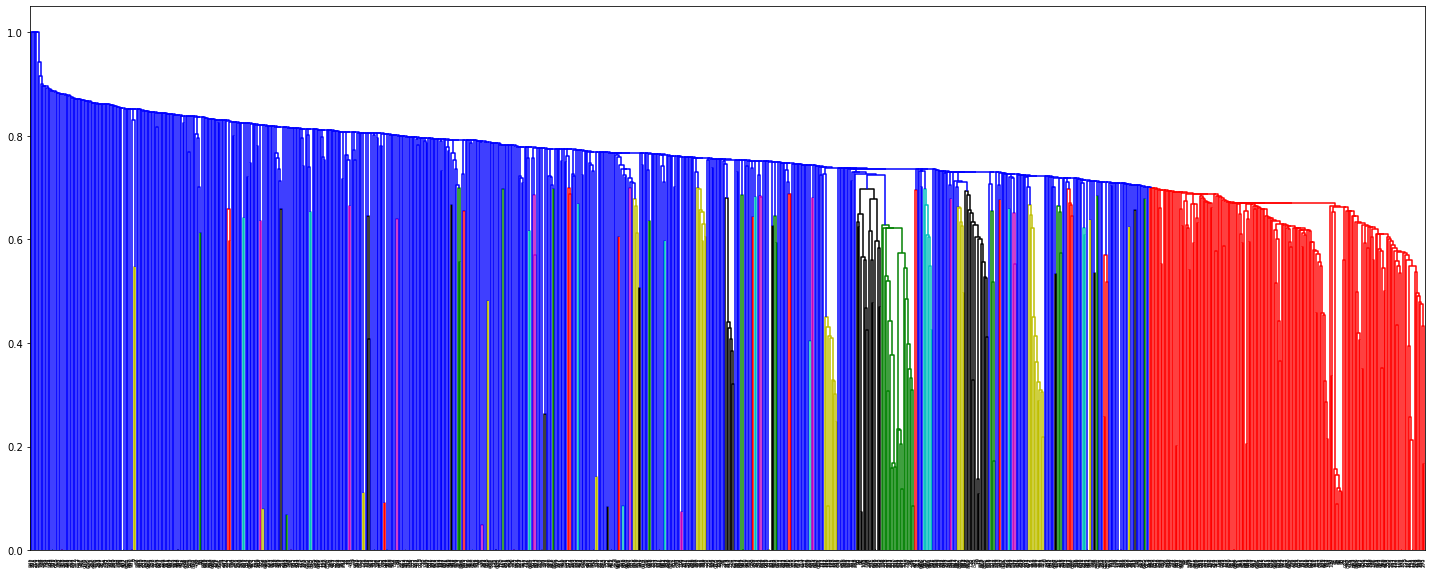

In [63]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z, count_sort = True)
plt.show()

In [70]:
fcluster(Z, t = 20, criterion = 'maxclust')

array([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  7,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  8,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 12,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  9,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 13,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 16,  2,  2,  2,  2,
        2,  2,  2,  2,  2